# an emission spectrum  check CH4



In [13]:
#
#   CH4 version Current Status: Feb. 21th (2021)
#
#   OK: forward JVP / HML RT alpha as a free parameter
#   Not work: primitive backward / alpha as a free parameter
#   Not implemented yet: VJP backward (something wrong for NumPyro) 
#
#   Current fiducial model: forward JVP
#   Updates:   planck nB (Feb.21/2021)
#
#   ToDo:
#   Q(T)
# 

In [14]:
# importing lpf modile in exojax.spec
%load_ext autoreload
%autoreload 2
from exojax.spec import rtransfer as rt
from exojax.spec import planck
from exojax.spec import moldb
from exojax.spec import make_numatrix0,xsvector
from exojax.spec.lpf import xsmatrix
from exojax.spec.clpf import cxsmatrix
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.plot.atmplot import plottau, plotcf
from exojax.spec.hitrancia import read_cia, logacia 
from exojax.spec.rtransfer import rtrun, dtaux 
import numpy as np
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from petitRADTRANS import Radtrans
import petitRADTRANS.nat_cst as nc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import jax.numpy as jnp
from jax import random
from jax import vmap, jit
plt.style.use('bmh')

## INPUT MODEL

In [ ]:
N=15000
wav=np.linspace(16280.0,16370.0,N,dtype=np.float64)#AA
nus=1.e8/wav[::-1]

#loading molecular database (HITRAN2012/CO)
#mdbCH4=moldb.MdbHit('/home/kawahara/exojax/data/CH4/06_hit12.par',nus)
#mdbCO=moldb.MdbHit('/home/kawahara/exojax/data/hitemp/CO/05_HITEMP2010.par',nus)
mdbCH4=moldb.MdbHit('/home/kawahara/exojax/data/hitemp/CH4/06_HITEMP2020.par',nus)
#-> will die

In [17]:
#petitRadtran
dat=pd.read_csv("ch4/Gl229/Gl229B_spectrum_CH4.dat",delimiter=" ",names=("WAV","VAL"))

NP=130
Nspecies=160
Parr=np.ones(NP)
Tarr=np.ones(NP)

### read header
data = open('ch4/Gl229/MMR/eq.dat', 'r')
line = data.read().split()
data.close()
molname = {}
for a in range(0,160):
    molname[a] = line[a+6]

data = open('ch4/Gl229/MMR/eq.dat', 'r')
a = 0
MMW_k = np.ones_like(Tarr)
MMR = np.zeros((Nspecies,NP))
for line in data:
    if line[0]=='#':
        continue
    lines = line.rstrip('\n').split()
    Parr[a] = lines[0]
    Tarr[a] = lines[1]
    MMW_k[a] = lines[2]
    for i in range(0,160):
        MMR[i,a] = lines[i+3]
    a = a + 1
data.close()

Tarr=jnp.array(Tarr)
Parr=jnp.array(Parr)

In [18]:
from exojax.utils.chopstacks import buildwall 
wParr=buildwall(Parr)
dParr=wParr[1:]-wParr[0:-1]

In [19]:
#partition function ratio
#mdbCO_HITRAN=moldb.MdbHit('/home/kawahara/exojax/data/CO','05_hit12',nus)
mdbCH4_hitran=moldb.MdbHit('/home/kawahara/exojax/data/CH4/06_hit12.par',nus)
qr=mdbCH4_hitran.Qr(Tarr)

In [20]:
#partitioning Q(T) for each line
qt=np.zeros((NP,len(mdbCH4.isoid)))
for idx,iso in enumerate(mdbCH4.uniqiso):
    mask=mdbCH4.isoid==iso
    for ilayer in range(NP):
        qt[ilayer,mask]=qr[ilayer,idx]

In [21]:
molname[19]

'C1H4'

In [22]:
from scipy.constants import  m_u
mmw=2.33 #mean molecular weight
molmass=16. #molecular mass
#mmr=0.01 #mass mixing ratio
mmr=MMR[19]
g=1.e5 # gravity cm/s2
Xco=mmr*mmw/molmass 
tfac=1.e3*Xco/(mmw*m_u*g)  

In [23]:
vmr=mmr*mmw/molmass 

In [39]:

Tref=296.0
SijM=vmap(SijT,(0,None,None,None,0))(Tarr,mdbCH4.logsij0,mdbCH4.nu_lines\
                                          ,mdbCH4.elower,qt)
gammaLM = vmap(gamma_hitran,(0,0,0,None,None,None))\
(Parr,Tarr,Parr, mdbCH4.n_air, mdbCH4.gamma_air, mdbCH4.gamma_self)
+ gamma_natural(mdbCH4.A) #uncomment if you inclide a natural width
sigmaDM=vmap(doppler_sigma,(None,0,None))(mdbCH4.nu_lines,Tarr,molmass)

In [40]:

nu0=mdbCH4.nu_lines
memory_size=15.0

d=int(memory_size/(len(nu0)*4/1024./1024.))
Ni=int(len(nus)/d)

d2=100
Nlayer=np.shape(SijM)[0]
Nline=np.shape(SijM)[1]
Nj=int(Nline/d2)
xsm=[]
for i in tqdm.tqdm(range(0,Ni+1)):
    s=int(i*d);e=int((i+1)*d);e=min(e,len(nus))
    xsmtmp=np.zeros((Nlayer,e-s))
    #line 
    for j in range(0,Nj+1):
        s2=int(j*d2);e2=int((j+1)*d2);e2=min(e2,Nline)
        numatrix=make_numatrix0(nus[s:e],nu0[s2:e2])
        xsmtmp=xsmtmp+\
        xsmatrix(numatrix,sigmaDM[:,s2:e2],gammaLM[:,s2:e2],SijM[:,s2:e2])
    if i==0:
        xsm=np.copy(xsmtmp.T)
    else:
        xsm = np.concatenate([xsm,xsmtmp.T])
xsm=xsm.T



100%|██████████| 86/86 [00:50<00:00,  1.68it/s]


## cheking d tau and contribution function

In [41]:
nucia,tcia,ac=read_cia("../../data/CIA/H2-H2_2011.cia",nus[0]-10.0,nus[-1]+10.0)



In [42]:
logac=jnp.array(np.log10(ac))
#logacia(Tarr,nus,nucia,tcia,logac)

In [43]:
jnp.shape(mfcia(Tarr,nus,nucia,tcia,logac))

NameError: name 'mfcia' is not defined

In [ ]:
#vfcia=vmap(fcia,(0,None),0)
#mfcia=vmap(vfcia,(None,0),0)

In [ ]:
kB=1.380649e-16
lognarr=jnp.log10((Parr*1.e6)/(kB*Tarr))#log number density cgs

In [ ]:
from scipy.constants import  m_u
m_ucgs=m_u*1.e3 #g

In [ ]:
logm_ucgs=np.log10(m_ucgs)

In [ ]:
logm_ucgs

In [ ]:
logkb=np.log10(kB)
logg=np.log10(g)
ddParr=dParr/Parr

In [ ]:
vmrh2=1.0
dtaucia=(10**(logacia(Tarr,nus,nucia,tcia,logac)+2*lognarr[:,None]+logkb-logg-logm_ucgs)\
         *Tarr[:,None]/mmw*ddParr[:,None]*vmrh2)
#log10(n2 ac)

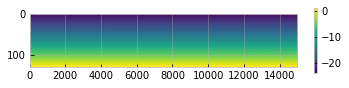

In [44]:
fig=plt.figure()
ax=fig.add_subplot(111)
c=ax.imshow(np.log10(dtaucia))

plt.colorbar(c,shrink=0.3)
ax.set_aspect(0.2/ax.get_data_ratio())

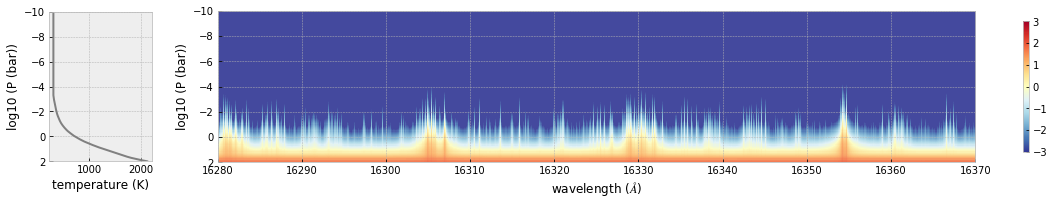

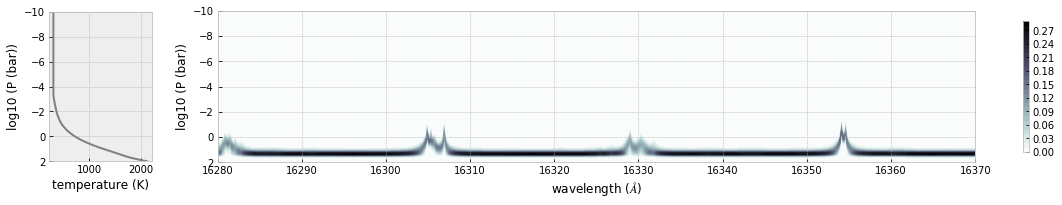

In [45]:
dtauM=dtaux(dParr,xsm,mmr*0.1,mmw,g)+dtaucia

plottau(nus,dtauM,Tarr,Parr,unit="AA") #tau
plt.savefig("../../documents/figures/plottau_ch4.png")
plotcf(nus,dtauM,Tarr,Parr,dParr,unit="AA") 
plt.savefig("../../documents/figures/plotcf_ch4.png")

In [46]:
sourcef=planck.piBarr(Tarr,nus)

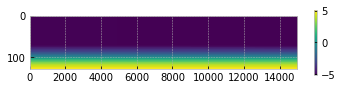

In [47]:
fig=plt.figure()
ax=fig.add_subplot(111)
c=ax.imshow(np.log10(sourcef))

plt.colorbar(c,shrink=0.3)
ax.set_aspect(0.2/ax.get_data_ratio())

In [48]:
from exojax.spec.rtransfer import rtrun, dtaux 
Fx0=rtrun(dtauM,sourcef)

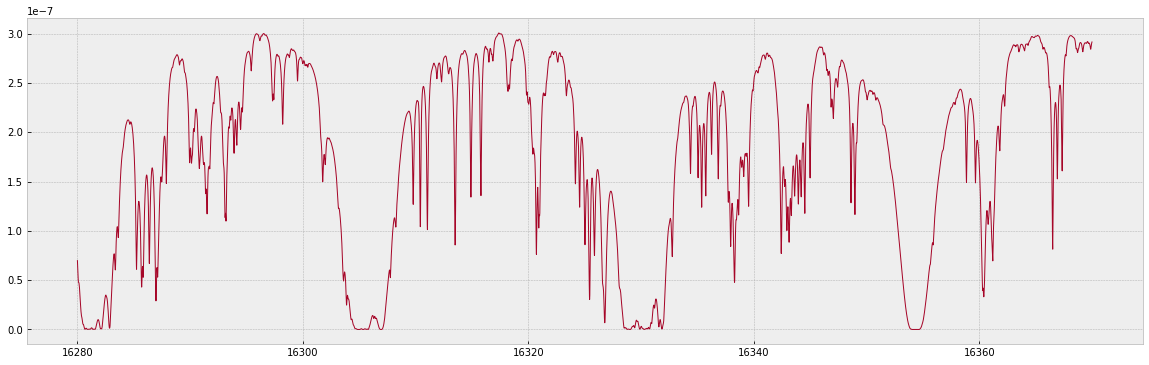

In [49]:
fig=plt.figure(figsize=(20,6.0))
plt.plot(wav[::-1],Fx0,lw=1,color="C1")
plt.savefig("highredCH4.png")

In [50]:
dat=pd.read_csv("ch4/Gl229/Gl229B_spectrum_CH4.dat",delimiter=",")

(0.0, 6e-07)

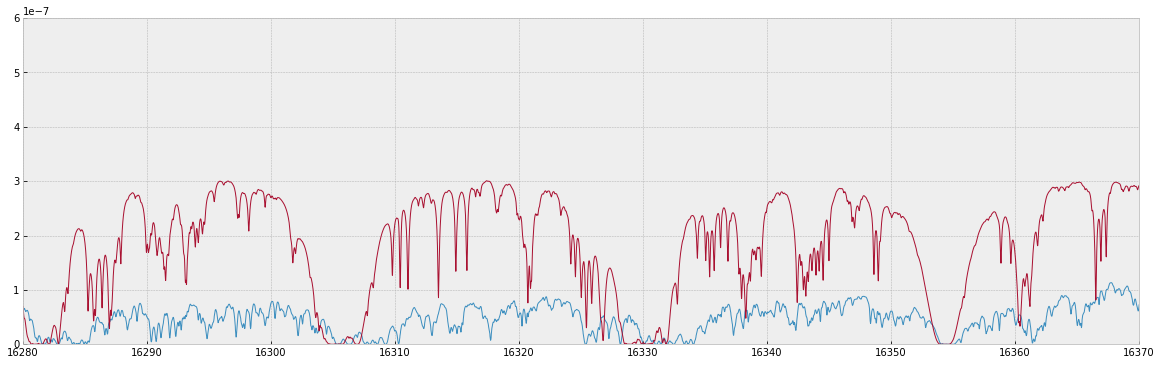

In [53]:
fig=plt.figure(figsize=(20,6.0))
plt.plot(dat["WAV"]*1.e4,dat["VAL"],lw=1,alpha=0.95)
plt.xlim(wav[0],wav[-1])
plt.plot(wav[::-1],Fx0,lw=1,color="C1",alpha=0.95)
plt.ylim(0.0,6.e-7)